# Name : Vilohit Keshava Murthy Achar

# ID : 23077751

# Name : Mohit Chandrashekhar Attarde

# ID : 23241977



# Statement: This code executes to the end without an error.

#  References

Link to original source which is reused: https://www.kaggle.com/code/ahmedmedhat1012/cbis-ddsm-breast-cancer-image-dataset-training

Link to version of dataset used: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/data

Case 1: InceptionResNetv2 https://www.kaggle.com/code/aruzhanimasheva/cbis-ddsm-breast-cancer-image-dataset-training

Case 2: Custom Setup https://www.kaggle.com/code/samrudhau/breast-cancer-detection 

Case 3: EfficentNetB2 https://www.kaggle.com/code/krsandeep06/efficientnet-cbis-ddsm/notebook

Case 4: VGG16 https://www.kaggle.com/code/ahmedmedhat1012/cbis-ddsm-breast-cancer-image-dataset-training


# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.regularizers import l2
from keras.applications import InceptionResNetV2,VGG19,VGG16
from keras.utils import plot_model

In [4]:
import tensorflow as tf
from tensorflow import keras
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os

# Data Import

In [5]:
# df for Image Path Data
dicom = pd.read_csv('CBIS-DDSM\csv\dicom_info.csv')
dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


## Sort image paths with index data

In [6]:
dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

N1: Creating dictionaries to map image path from DICOM to Mass and Calc Dataset

In [7]:
cropped_images = dicom[dicom.SeriesDescription=='cropped images'].image_path
mammo_images = dicom[dicom.SeriesDescription=='full mammogram images'].image_path
roi_mask_images = dicom[dicom.SeriesDescription=='ROI mask images'].image_path

In [8]:
# maps mammogram, cropped, and ROI image paths to keys for easy access and demonstrates retrieving an item.
mammo_dict = dict()
cropped_images_dict = dict()
roi_image_dict = dict()

for dicom in mammo_images:
    key = dicom.split("/")[2]
    mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[2]
    cropped_images_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[2]
    roi_image_dict[key] = dicom

next(iter((mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 'CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [9]:
print(cropped_images)

0        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10       CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
                               ...                        
10225    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374221...
10227    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.195242...
10229    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.263713...
10231    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.627982...
10236    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.285138...
Name: image_path, Length: 3567, dtype: object


In [10]:
print(mammo_images)

1        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2        CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11       CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12       CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15       CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
                               ...                        
10220    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.744141...
10223    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.273069...
10224    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.192830...
10233    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.824512...
10234    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.247594...
Name: image_path, Length: 2857, dtype: object


## Mass Dataset

In [11]:
# updates dataframe with correct paths for mass images using existing dictionaries to map names to paths.
def fix_mass_image_path(data):
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]

In [12]:
# loads mass case descriptions for training and testing sets from CSV files into pandas dataframes
mass_train = pd.read_csv('CBIS-DDSM/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('CBIS-DDSM/csv/mass_case_description_test_set.csv')

mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [13]:
fix_mass_image_path(mass_train)
fix_mass_image_path(mass_test)

In [14]:
mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128573...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [15]:
# rename columnns names
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [16]:
mass_train.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128573...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [17]:
mass_test.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245063...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308205...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.859522...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381440...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221311...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212143...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239949...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154030...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215081...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199593...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [18]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

mass_test['mass_margins'] = mass_test['mass_margins'].bfill()


mass_train.isnull().sum()
mass_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [19]:
# check datasets shape
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


## Calc Case Dataset

In [20]:
# updates dataframe with correct paths for mass images using existing dictionaries to map names to paths.
def fix_calc_image_path(data):
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]

In [21]:
# loads calc case descriptions for training and testing sets from CSV files into pandas dataframes.

calc_train = pd.read_csv('CBIS-DDSM/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('CBIS-DDSM/csv/calc_case_description_test_set.csv')

calc_train.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [22]:
# rename columnns names
calc_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

calc_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [23]:
fix_calc_image_path(calc_train)
fix_calc_image_path(calc_test)

In [24]:
calc_train.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.128573...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [25]:
calc_test.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245063...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.308205...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.859522...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381440...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221311...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.212143...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239949...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.154030...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215081...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.199593...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [26]:
# fills missing values in specific columns and checks for nulls in train and test datasets.

calc_train['mass_shape'] = calc_train['mass_shape'].bfill()
calc_train['mass_margins'] = calc_train['mass_margins'].bfill()

calc_test['mass_margins'] = calc_test['mass_margins'].bfill()

calc_train.isnull().sum()
calc_test.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

# Visualizations

## Data Visualizaton of Mass Case

C:\Users\mohit\AppData\Local\Temp\ipykernel_22928\3548263498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pathology', data=mass_train, palette='Set1') # You can specify any other palette name


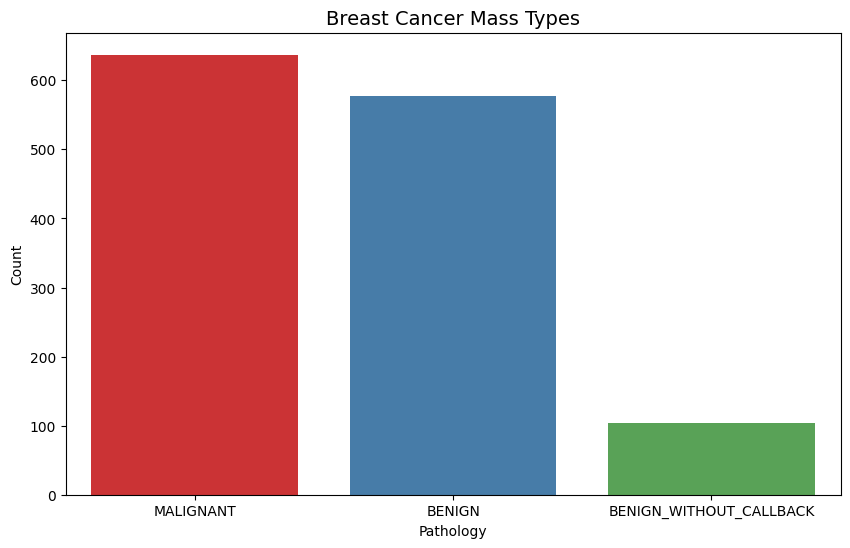

In [79]:
# ploting the distribution of breast cancer mass types in the training dataset as a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='pathology', data=mass_train, palette='Set1')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.show()


## Corelations in Mass type Training data

In [45]:
# converts 'pathology' to numeric, creates a subset with numerical features, and computes their correlation matrix.

mass_train['pathology_numeric'] = mass_train['pathology'].map({'BENIGN': 0, 'MALIGNANT': 1})
numerical_data = mass_train[['breast_density', 'assessment', 'subtlety', 'pathology_numeric']]
correlation_matrix = numerical_data.corr()
correlation_matrix

,breast_density,assessment,subtlety,pathology_numeric
breast_density,1.000000,0.060066,-0.290062,-0.048099
assessment,0.060066,1.000000,0.076325,0.503043
subtlety,-0.290062,0.076325,1.000000,0.033218
pathology_numeric,-0.048099,0.503043,0.033218,1.000000


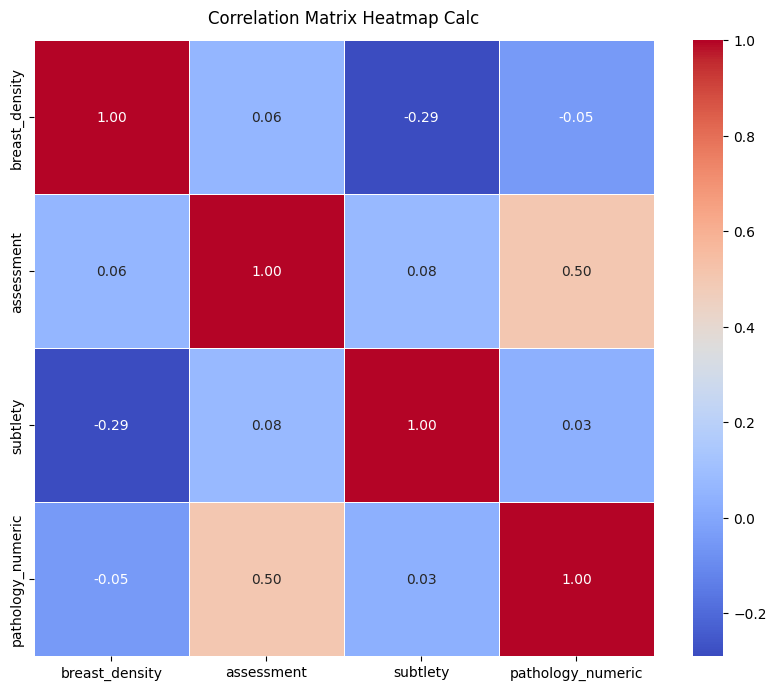

In [46]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
heatmap.set_title('Correlation Matrix Heatmap Mass', fontdict={'fontsize':12}, pad=12)
plt.show()

## Visalization of Calc type Data

C:\Users\mohit\AppData\Local\Temp\ipykernel_22928\3111922203.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pathology', data=calc_train, palette='Set1')


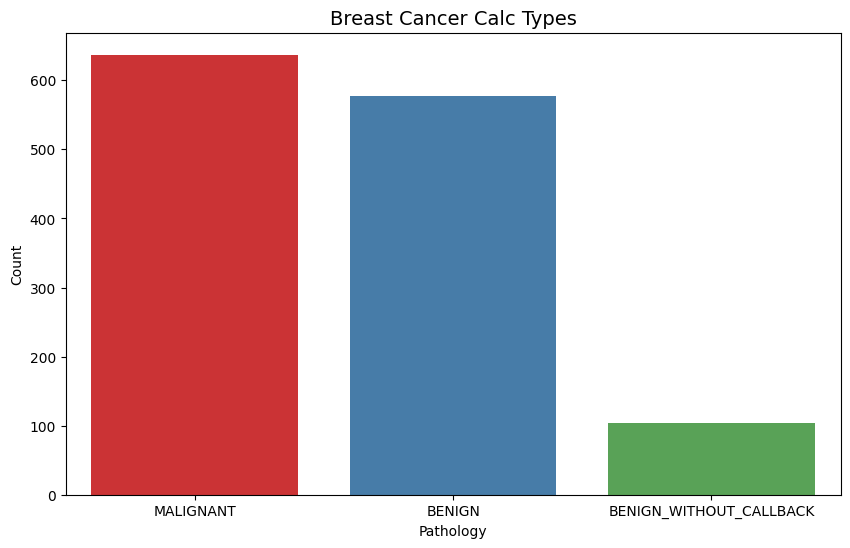

In [81]:
# ploting the distribution of breast cancer mass types in the training dataset as a bar chart
plt.figure(figsize=(10, 6))
sns.countplot(x='pathology', data=calc_train, palette='Set1')
plt.title('Breast Cancer Calc Types', fontsize=14)
plt.xlabel('Pathology')
plt.ylabel('Count')
plt.show()


## Corelations in Calc type Training data

In [47]:
# converts 'pathology' to numeric, creates a subset with numerical features, and computes their correlation matrix.

calc_train['pathology_numeric'] = calc_train['pathology'].map({'BENIGN': 0, 'MALIGNANT': 1})
numerical_data = calc_train[['breast_density', 'assessment', 'subtlety', 'pathology_numeric']]
correlation_matrix = numerical_data.corr()
correlation_matrix

,breast_density,assessment,subtlety,pathology_numeric
breast_density,1.000000,0.060066,-0.290062,-0.048099
assessment,0.060066,1.000000,0.076325,0.503043
subtlety,-0.290062,0.076325,1.000000,0.033218
pathology_numeric,-0.048099,0.503043,0.033218,1.000000


Full Mammograms:



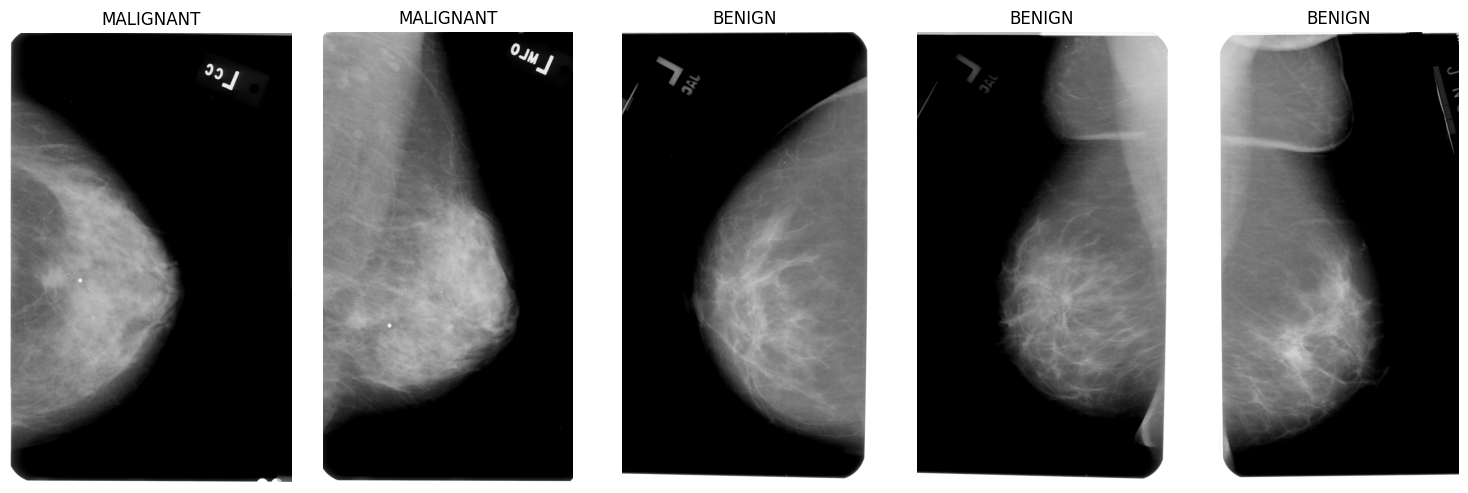

Cropped Mammograms:



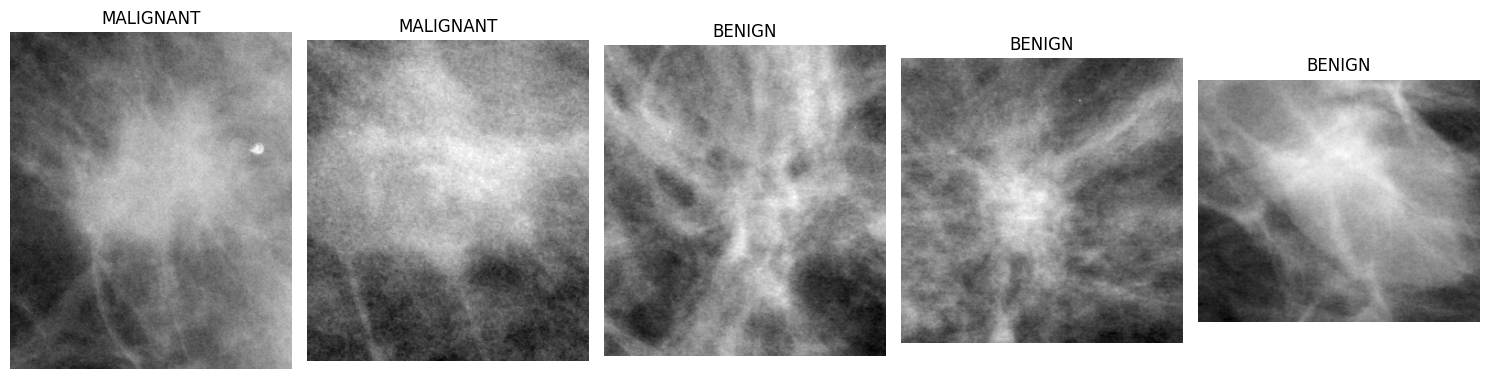

In [31]:
import matplotlib.image as mpimg

def display_images(column, number):
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))
    
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

print('Full Mammograms:\n')
display_images('image_file_path', 5)
print('Cropped Mammograms:\n')
display_images('cropped_image_file_path',5)

# Preprocessing function

N2: Mapping classes to labels

In [32]:
# loads, converts, resizes images for CNN input, and normalizes pixel values.
def image_processor(image_path, target_size):
    absolute_image_path = os.path.abspath(image_path)
    image = cv2.imread(absolute_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (target_size[1], target_size[0]))
    image_array = image / 255.0
    return image_array

## Preprocessing Images of Mass Type

In [83]:
full_mass = pd.concat([mass_train, mass_test], axis=0)
target_size = (224, 224, 3)
full_mass['processed_images'] = full_mass['image_file_path'].apply(lambda x: image_processor(x, target_size))
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 
X_resized = np.array(full_mass['processed_images'].tolist())
full_mass['labels'] = full_mass['pathology'].replace(class_mapper)
num_classes = len(full_mass['labels'].unique())

## Preprocessing of Images of Calc Type

In [34]:
full_mass1 = pd.concat([calc_train, calc_test], axis=0)
target_size1 = (224, 224, 3)
full_mass1['processed_images'] = full_mass1['image_file_path'].apply(lambda x: image_processor(x, target_size))
class_mapper1 = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 
X_resized1 = np.array(full_mass['processed_images'].tolist())
full_mass1['labels'] = full_mass['pathology'].replace(class_mapper)
num_classes1 = len(full_mass['labels'].unique())


## Mass type train data split

In [35]:
# splitting of dataset into train and test data.
X_train, X_test, y_train, y_test = train_test_split(X_resized, full_mass['labels'].values, test_size = 0.2, random_state = 42)

print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (1356, 224, 224, 3)
X_test shape : (340, 224, 224, 3)
y_train shape : (1356,)
y_test shape : (340,)


## Calc type train data split

In [36]:
# splitting of dataset into train and test data.
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resized1, full_mass['labels'].values, test_size = 0.2, random_state = 42)

print('X_train1 shape : {}' .format(X_train.shape))
print('X_test1 shape : {}' .format(X_test.shape))
print('y_train1 shape : {}' .format(y_train.shape))
print('y_test1 shape : {}' .format(y_test.shape))

X_train1 shape : (1356, 224, 224, 3)
X_test1 shape : (340, 224, 224, 3)
y_train1 shape : (1356,)
y_test1 shape : (340,)


# Mass type images display

In [37]:
num_examples_per_class = 5

malignant_indices = np.where(y_train == 1)[0]
benign_indices = np.where(y_train == 0)[0]

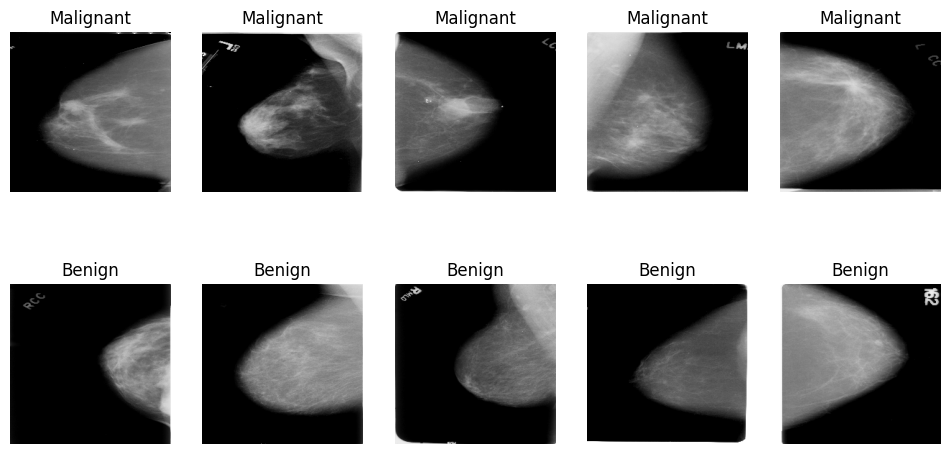

In [38]:
# displays sample images of malignant and benign classes from the training set.

malignant_examples = X_train[malignant_indices[:num_examples_per_class]]
benign_examples = X_train[benign_indices[:num_examples_per_class]]

plt.figure(figsize=(12, 6))
for i in range(num_examples_per_class):
    plt.subplot(2, num_examples_per_class, i + 1)
    plt.imshow(malignant_examples[i])
    plt.title('Malignant')
    plt.axis('off')

    plt.subplot(2, num_examples_per_class, num_examples_per_class + i + 1)
    plt.imshow(benign_examples[i])
    plt.title('Benign')
    plt.axis('off')

plt.show()


Text(0.5, 1.0, '0')

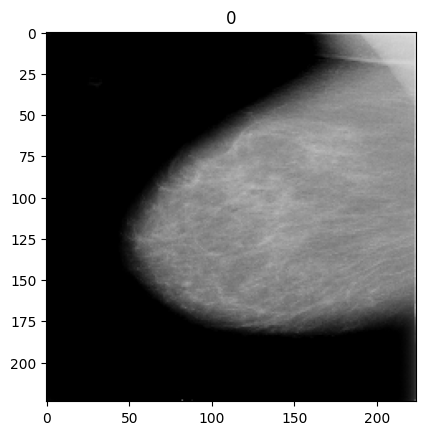

In [39]:
index = 1
plt.imshow(X_train[index])
plt.title(y_train[index])

# Calc type images display

In [40]:
num_examples_per_class1 = 5

malignant_indices1 = np.where(y_train1 == 1)[0]
benign_indices1 = np.where(y_train1 == 0)[0]

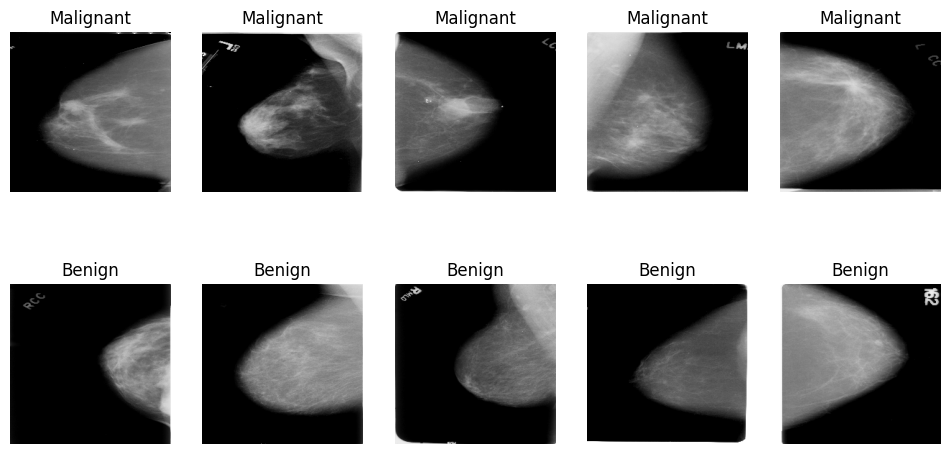

In [41]:
# displays sample images of malignant and benign classes from the training set.
malignant_examples1 = X_train1[malignant_indices1[:num_examples_per_class1]]
benign_examples1 = X_train1[benign_indices1[:num_examples_per_class1]]

plt.figure(figsize=(12, 6))
for i in range(num_examples_per_class1):
    plt.subplot(2, num_examples_per_class1, i + 1)
    plt.imshow(malignant_examples1[i])
    plt.title('Malignant')
    plt.axis('off')

    plt.subplot(2, num_examples_per_class1, num_examples_per_class1 + i + 1)
    plt.imshow(benign_examples1[i])
    plt.title('Benign')
    plt.axis('off')

plt.show()

Text(0.5, 1.0, '0')

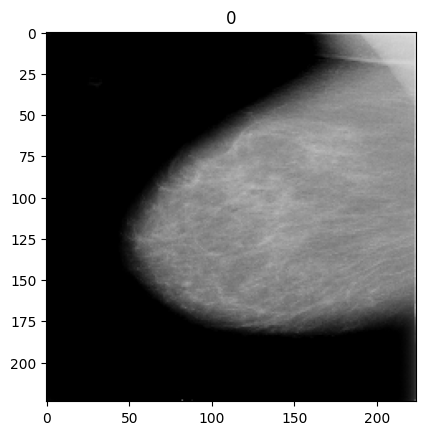

In [42]:
index = 1
plt.imshow(X_train1[index])
plt.title(y_train1[index])

# N3: CNN VGG16 Architecture with Binary Cross Entropy and Adam Optimizer

## Model for Mass 

In [ ]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

image_size=224
train_data_augmented = train_datagen.flow(X_train, y_train, batch_size=16)

mode = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in mode.layers[:-5]:
    layer.trainable = False

model = tf.keras.Sequential([mode,
    Flatten(),
    Dense(128, activation='relu'
          , kernel_regularizer=l2(0.01)
         ),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 40 , batch_size = 75)



Epoch 1/40


19/19 [==============================] - 108s 6s/step - loss: 2.9771 - accuracy: 0.5361 - val_loss: 2.5645 - val_accuracy: 0.6618
Epoch 2/40
19/19 [==============================] - 106s 6s/step - loss: 2.2955 - accuracy: 0.6718 - val_loss: 2.0733 - val_accuracy: 0.6059
Epoch 3/40
19/19 [==============================] - 108s 6s/step - loss: 1.8522 - accuracy: 0.6726 - val_loss: 1.6854 - val_accuracy: 0.6559
Epoch 4/40
19/19 [==============================] - 105s 6s/step - loss: 1.4790 - accuracy: 0.7338 - val_loss: 1.4344 - val_accuracy: 0.6824
Epoch 5/40
19/19 [==============================] - 104s 6s/step - loss: 1.1940 - accuracy: 0.7810 - val_loss: 1.2464 - val_accuracy: 0.6706
Epoch 6/40
19/19 [==============================] - 110s 6s/step - loss: 0.9685 - accuracy: 0.8193 - val_loss: 1.1387 - val_accuracy: 0.6853
Epoch 7/40
19/19 [==============================] - 108s 6s/step - loss: 0.8056 - accuracy: 0.8555 - val_loss: 1.0828 - val_accuracy: 0.7176
Epoch 8/4

In [ ]:
# evaluating the model score.
model.evaluate(X_test, y_test)

11/11 [==============================] - 19s 2s/step - loss: 1.2247 - accuracy: 0.7324


[1.224741816520691, 0.7323529124259949]

In [ ]:
# saving the the trained model into our local system for future testing.
model.save('Model.keras')

In [ ]:
# iterates through model layers, prints their configurations and trainable status.
for layer in model.layers:
    config = layer.get_config()
    
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")
    
    for param, value in config.items():
        print(f"  {param}: {value}")
    if hasattr(layer, 'trainable'):
        print(f"  Trainable: {layer.trainable}")

Layer: vgg16 (Functional)
  name: vgg16
  trainable: True
  layers: [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None, 'name': 'input_1', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_

In [ ]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
E_in = 1 - train_accuracy
E_out = 1 - test_accuracy

print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'E_in (In-sample Error): {E_in:.4f}')

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'E_out (Out-of-sample Error): {E_out:.4f}')

Training Loss: 0.0875
Training Accuracy: 0.9963
E_in (In-sample Error): 0.0037
Test Loss: 1.2247
Test Accuracy: 0.7324
E_out (Out-of-sample Error): 0.2676


## Model1 for Calc

In [ ]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.
train_datagen1 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

image_size=224
train_data_augmented = train_datagen1.flow(X_train1, y_train1, batch_size=16)

mode = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in mode.layers[:-5]:
    layer.trainable = False

model1 = tf.keras.Sequential([mode,
    Flatten(),
    Dense(128, activation='relu'
          , kernel_regularizer=l2(0.01)
         ),
    Dense(1, activation='sigmoid')
])


model1.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

history1 = model1.fit(X_train1, y_train1, validation_data = (X_test1, y_test1), epochs = 40 , batch_size = 75)

Epoch 1/40
19/19 [==============================] - 106s 6s/step - loss: 2.9992 - accuracy: 0.5088 - val_loss: 2.5833 - val_accuracy: 0.6412
Epoch 2/40
19/19 [==============================] - 103s 5s/step - loss: 2.3220 - accuracy: 0.6010 - val_loss: 2.0418 - val_accuracy: 0.6471
Epoch 3/40
19/19 [==============================] - 104s 6s/step - loss: 1.8431 - accuracy: 0.6445 - val_loss: 1.6524 - val_accuracy: 0.6559
Epoch 4/40
19/19 [==============================] - 103s 5s/step - loss: 1.4837 - accuracy: 0.7013 - val_loss: 1.3874 - val_accuracy: 0.6559
Epoch 5/40
19/19 [==============================] - 104s 6s/step - loss: 1.2366 - accuracy: 0.7109 - val_loss: 1.2202 - val_accuracy: 0.6853
Epoch 6/40
19/19 [==============================] - 103s 5s/step - loss: 1.0142 - accuracy: 0.7537 - val_loss: 1.2265 - val_accuracy: 0.5882
Epoch 7/40
19/19 [==============================] - 102s 5s/step - loss: 0.9302 - accuracy: 0.7360 - val_loss: 0.9764 - val_accuracy: 0.6882
Epoch 8/40
19

In [ ]:
# evaluating the model score.
model1.evaluate(X_test1, y_test1)

11/11 [==============================] - 19s 2s/step - loss: 1.4531 - accuracy: 0.6971


[1.45307457447052, 0.6970587968826294]

In [ ]:
#saving the model in our local system for future testing.
model1.save('Model1.keras')

In [ ]:
# iterates through model layers, prints their configurations and trainable status.
for layer in model1.layers:
    config = layer.get_config()
    
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")
    
    for param, value in config.items():
        print(f"  {param}: {value}")
    if hasattr(layer, 'trainable'):
        print(f"  Trainable: {layer.trainable}")

Layer: vgg16 (Functional)
  name: vgg16
  trainable: True
  layers: [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_

In [ ]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.

train_loss1, train_accuracy1 = model1.evaluate(X_train1, y_train1, verbose=0)
test_loss1, test_accuracy1 = model1.evaluate(X_test1, y_test1, verbose=0)
E_in1 = 1 - train_accuracy1
E_out1 = 1 - test_accuracy1

print(f'Training Loss: {train_loss1:.4f}')
print(f'Training Accuracy: {train_accuracy1:.4f}')
print(f'E_in (In-sample Error): {E_in1:.4f}')

print(f'Test Loss: {test_loss1:.4f}')
print(f'Test Accuracy: {test_accuracy1:.4f}')
print(f'E_out (Out-of-sample Error): {E_out1:.4f}')

Training Loss: 0.0648
Training Accuracy: 0.9963
E_in (In-sample Error): 0.0037
Test Loss: 1.4531
Test Accuracy: 0.6971
E_out (Out-of-sample Error): 0.3029


# KFold Cross Validation

N4: 5 Fold Cross Validation Applied

## For Mass

In [90]:
from sklearn.model_selection import KFold

# define the number of folds
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# perform K-fold cross-validation
for train_index, test_index in kfold.split(X_resized):
    X_train2, X_test2 = X_resized[train_index], X_resized[test_index]
    y_train2, y_test2 = full_mass['labels'].values[train_index], full_mass['labels'].values[test_index]

## For Calc 

In [ ]:
kfold1 = KFold(n_splits=5, shuffle=True, random_state=42)

# perform K-fold cross-validation
for train_index, test_index in kfold1.split(X_resized1):
    X_train3, X_test3 = X_resized1[train_index], X_resized[test_index]
    y_train3, y_test3 = full_mass['labels'].values[train_index], full_mass['labels'].values[test_index]

## Model2 for Mass

In [ ]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.
train_datagen2 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

image_size=224
train_data_augmented = train_datagen2.flow(X_train2, y_train2, batch_size=16)

mode = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in mode.layers[:-5]:
    layer.trainable = False

model2 = tf.keras.Sequential([mode,
    Flatten(),
    Dense(128, activation='relu'
          , kernel_regularizer=l2(0.01)
         ),
    Dense(1, activation='sigmoid')
])


model2.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

history2 = model2.fit(X_train1, y_train1, validation_data = (X_test2, y_test2), epochs = 40 , batch_size = 75)

Epoch 1/40
19/19 [==============================] - 122s 6s/step - loss: 2.9664 - accuracy: 0.5479 - val_loss: 2.5644 - val_accuracy: 0.5693
Epoch 2/40
19/19 [==============================] - 105s 6s/step - loss: 2.3023 - accuracy: 0.6482 - val_loss: 2.0016 - val_accuracy: 0.6785
Epoch 3/40
19/19 [==============================] - 105s 6s/step - loss: 1.8286 - accuracy: 0.6822 - val_loss: 1.5975 - val_accuracy: 0.7168
Epoch 4/40
19/19 [==============================] - 105s 6s/step - loss: 1.4580 - accuracy: 0.7345 - val_loss: 1.2416 - val_accuracy: 0.8230
Epoch 5/40
19/19 [==============================] - 104s 6s/step - loss: 1.1630 - accuracy: 0.7795 - val_loss: 0.9746 - val_accuracy: 0.8702
Epoch 6/40
19/19 [==============================] - 104s 6s/step - loss: 0.9614 - accuracy: 0.8060 - val_loss: 0.8112 - val_accuracy: 0.8702
Epoch 7/40
19/19 [==============================] - 109s 6s/step - loss: 0.7864 - accuracy: 0.8473 - val_loss: 0.7258 - val_accuracy: 0.8496
Epoch 8/40
19

In [ ]:
# evaluating the model score.
model2.evaluate(X_test2, y_test2)

11/11 [==============================] - 20s 2s/step - loss: 0.0828 - accuracy: 1.0000


[0.08281727880239487, 1.0]

In [ ]:
#saving the model in our local system for future testing.
model2.save('Model2.keras')

In [ ]:
# iterates through model layers, prints their configurations and trainable status.
for layer in model2.layers:
    config = layer.get_config()
    
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")
    
    for param, value in config.items():
        print(f"  {param}: {value}")
    if hasattr(layer, 'trainable'):
        print(f"  Trainable: {layer.trainable}")

Layer: vgg16 (Functional)
  name: vgg16
  trainable: True
  layers: [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_3'}, 'registered_name': None, 'name': 'input_3', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_

In [ ]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.
train_loss2, train_accuracy2 = model2.evaluate(X_train2, y_train2, verbose=0)
test_loss2, test_accuracy2 = model2.evaluate(X_test2, y_test2, verbose=0)
E_in2 = 1 - train_accuracy2
E_out2 = 1 - test_accuracy2

print(f'Training Loss: {train_loss2:.4f}')
print(f'Training Accuracy: {train_accuracy2:.4f}')
print(f'E_in (In-sample Error): {E_in2:.4f}')

print(f'Test Loss: {test_loss2:.4f}')
print(f'Test Accuracy: {test_accuracy2:.4f}')
print(f'E_out (Out-of-sample Error): {E_out2:.4f}')

Training Loss: 0.4311
Training Accuracy: 0.9278
E_in (In-sample Error): 0.0722
Test Loss: 0.0828
Test Accuracy: 1.0000
E_out (Out-of-sample Error): 0.0000


## Model3 for Calc

In [ ]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.
train_datagen3 = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

image_size=224
train_data_augmented = train_datagen3.flow(X_train3, y_train3, batch_size=16)

mode = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in mode.layers[:-5]:
    layer.trainable = False

model3 = tf.keras.Sequential([mode,
    Flatten(),
    Dense(128, activation='relu'
          , kernel_regularizer=l2(0.01)
         ),
    Dense(1, activation='sigmoid')
])


model3.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

history3 = model3.fit(X_train3, y_train3, validation_data = (X_test3, y_test3), epochs = 40 , batch_size = 75)

Epoch 1/40
19/19 [==============================] - 107s 6s/step - loss: 2.9774 - accuracy: 0.5711 - val_loss: 2.6015 - val_accuracy: 0.5487
Epoch 2/40
19/19 [==============================] - 113s 6s/step - loss: 2.3367 - accuracy: 0.6094 - val_loss: 2.0654 - val_accuracy: 0.6165
Epoch 3/40
19/19 [==============================] - 108s 6s/step - loss: 1.8618 - accuracy: 0.6566 - val_loss: 1.6800 - val_accuracy: 0.6401
Epoch 4/40
19/19 [==============================] - 109s 6s/step - loss: 1.5272 - accuracy: 0.6706 - val_loss: 1.4075 - val_accuracy: 0.6313
Epoch 5/40
19/19 [==============================] - 110s 6s/step - loss: 1.2463 - accuracy: 0.7207 - val_loss: 1.2478 - val_accuracy: 0.6254
Epoch 6/40
19/19 [==============================] - 111s 6s/step - loss: 1.0510 - accuracy: 0.7561 - val_loss: 1.1282 - val_accuracy: 0.6755
Epoch 7/40
19/19 [==============================] - 110s 6s/step - loss: 0.8926 - accuracy: 0.7892 - val_loss: 1.0055 - val_accuracy: 0.6814
Epoch 8/40
19

In [ ]:
# evaluating the model score.
model3.evaluate(X_test3, y_test3)

11/11 [==============================] - 19s 2s/step - loss: 1.2262 - accuracy: 0.7316


[1.2262417078018188, 0.7315634489059448]

In [ ]:
#saving the model in our local system for future testing.
model3.save('Model3.keras')

In [ ]:
# iterates through model layers, prints their configurations and trainable status.
for layer in model3.layers:
    config = layer.get_config()
    
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")
    
    for param, value in config.items():
        print(f"  {param}: {value}")
    if hasattr(layer, 'trainable'):
        print(f"  Trainable: {layer.trainable}")

Layer: vgg16 (Functional)
  name: vgg16
  trainable: True
  layers: [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_4'}, 'registered_name': None, 'name': 'input_4', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_

In [ ]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.

train_loss3, train_accuracy3 = model3.evaluate(X_train3, y_train3, verbose=0)
test_loss3, test_accuracy3 = model3.evaluate(X_test3, y_test3, verbose=0)
E_in3 = 1 - train_accuracy3
E_out3 = 1 - test_accuracy3

print(f'Training Loss: {train_loss3:.4f}')
print(f'Training Accuracy: {train_accuracy3:.4f}')
print(f'E_in (In-sample Error): {E_in3:.4f}')

print(f'Test Loss: {test_loss3:.4f}')
print(f'Test Accuracy: {test_accuracy3:.4f}')
print(f'E_out (Out-of-sample Error): {E_out3:.4f}')

Training Loss: 0.0789
Training Accuracy: 0.9956
E_in (In-sample Error): 0.0044
Test Loss: 1.2262
Test Accuracy: 0.7316
E_out (Out-of-sample Error): 0.2684


# N5: Varying hyperparameters to Categorical Cross Entropy and RMSProp for checking their impact

## Model4 for Mass

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
# converts class labels to one-hot encoded vectors for both training and testing datasets.
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

In [ ]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.

train_datagen = ImageDataGenerator(
    rotation_range=30,  # slightly less rotation
    width_shift_range=0.1,  # less width shift
    height_shift_range=0.1,  # less height shift
    shear_range=0.1,  # less shear
    zoom_range=0.1,  # less zoom
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=10)  # less channel shift

train_data_augmented = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)


model_base = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in model_base.layers[:-5]:
    layer.trainable = False

model4 = Sequential([
    model_base,
    Flatten(),
    Dense(256, activation='elu', kernel_regularizer=l2(0.005)),  # More units, different activation, different regularization
    Dense(10, activation='softmax')  # Assuming 10 classes for multi-class classification
])

model4.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])


history4 = model4.fit(train_data_augmented, validation_data=(X_test, y_test_one_hot), epochs=30)

Epoch 1/30
43/43 [==============================] - 108s 2s/step - loss: 3.4009 - accuracy: 0.5170 - val_loss: 3.2349 - val_accuracy: 0.4971
Epoch 2/30
43/43 [==============================] - 105s 2s/step - loss: 3.1943 - accuracy: 0.5096 - val_loss: 3.2120 - val_accuracy: 0.4824
Epoch 3/30
43/43 [==============================] - 107s 3s/step - loss: 3.1287 - accuracy: 0.5295 - val_loss: 3.0651 - val_accuracy: 0.5765
Epoch 4/30
43/43 [==============================] - 105s 2s/step - loss: 3.0885 - accuracy: 0.5066 - val_loss: 3.0553 - val_accuracy: 0.5265
Epoch 5/30
43/43 [==============================] - 106s 2s/step - loss: 3.0380 - accuracy: 0.5081 - val_loss: 2.9991 - val_accuracy: 0.5235
Epoch 6/30
43/43 [==============================] - 108s 3s/step - loss: 2.9962 - accuracy: 0.5465 - val_loss: 2.9278 - val_accuracy: 0.6000
Epoch 7/30
43/43 [==============================] - 104s 2s/step - loss: 2.9399 - accuracy: 0.5347 - val_loss: 2.8787 - val_accuracy: 0.6206
Epoch 8/30
43

In [ ]:
# evaluating the model score.
model4.evaluate(X_test, y_test_one_hot)

11/11 [==============================] - 19s 2s/step - loss: 2.0766 - accuracy: 0.5000


[2.0765764713287354, 0.5]

In [ ]:
# saving the the trained model into our local system for future testing.
model4.save('Model4.keras')

In [ ]:
# iterates through model layers, prints their configurations and trainable status.
for layer in model4.layers:
    config = layer.get_config()
    
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")
    
    for param, value in config.items():
        print(f"  {param}: {value}")
    if hasattr(layer, 'trainable'):
        print(f"  Trainable: {layer.trainable}")

Layer: vgg16 (Functional)
  name: vgg16
  trainable: True
  layers: [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_5'}, 'registered_name': None, 'name': 'input_5', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_

In [ ]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.
train_loss4, train_accuracy4 = model4.evaluate(X_train, y_train_one_hot, verbose=0)
test_loss4, test_accuracy4 = model4.evaluate(X_test, y_test_one_hot, verbose=0)
E_in4 = 1 - train_accuracy4
E_out4 = 1 - test_accuracy4

print(f'Training Loss: {train_loss4:.4f}')
print(f'Training Accuracy: {train_accuracy4:.4f}')
print(f'E_in (In-sample Error): {E_in4:.4f}')

print(f'Test Loss: {test_loss4:.4f}')
print(f'Test Accuracy: {test_accuracy4:.4f}')
print(f'E_out (Out-of-sample Error): {E_out4:.4f}')

Training Loss: 2.0336
Training Accuracy: 0.5605
E_in (In-sample Error): 0.4395
Test Loss: 2.0766
Test Accuracy: 0.5000
E_out (Out-of-sample Error): 0.5000


## Model5 for Calc

In [ ]:
# converts class labels to one-hot encoded vectors for both training and testing datasets.
y_train_one_hot1 = to_categorical(y_train1, num_classes=10)
y_test_one_hot1 = to_categorical(y_test1, num_classes=10)

In [ ]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.

train_datagen = ImageDataGenerator(
    rotation_range=30,  # slightly less rotation
    width_shift_range=0.1,  # less width shift
    height_shift_range=0.1,  # less height shift
    shear_range=0.1,  # less shear
    zoom_range=0.1,  # less zoom
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=10)  # less channel shift


train_data_augmented = train_datagen.flow(X_train1, y_train_one_hot1, batch_size=32)


model_base = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in model_base.layers[:-5]:
    layer.trainable = False


model5 = Sequential([
    model_base,
    Flatten(),
    Dense(256, activation='elu', kernel_regularizer=l2(0.005)),  # More units, different activation, different regularization
    Dense(10, activation='softmax')  # Assuming 10 classes for multi-class classification
])

model5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])


history5 = model5.fit(train_data_augmented, validation_data=(X_test1, y_test_one_hot1), epochs=30, callbacks=[early_stopping])

Epoch 1/30
43/43 [==============================] - 108s 2s/step - loss: 3.4033 - accuracy: 0.5044 - val_loss: 3.1953 - val_accuracy: 0.5500
Epoch 2/30
43/43 [==============================] - 107s 2s/step - loss: 3.1918 - accuracy: 0.5147 - val_loss: 3.1518 - val_accuracy: 0.5059
Epoch 3/30
43/43 [==============================] - 105s 2s/step - loss: 3.1382 - accuracy: 0.5199 - val_loss: 3.1602 - val_accuracy: 0.4735
Epoch 4/30
43/43 [==============================] - 105s 2s/step - loss: 3.0878 - accuracy: 0.5103 - val_loss: 3.0556 - val_accuracy: 0.5294
Epoch 5/30
43/43 [==============================] - 107s 3s/step - loss: 3.0389 - accuracy: 0.5324 - val_loss: 3.0191 - val_accuracy: 0.5147
Epoch 6/30
43/43 [==============================] - 105s 2s/step - loss: 2.9908 - accuracy: 0.5376 - val_loss: 3.0711 - val_accuracy: 0.4853
Epoch 7/30
43/43 [==============================] - 104s 2s/step - loss: 2.9443 - accuracy: 0.5251 - val_loss: 2.9187 - val_accuracy: 0.5353
Epoch 8/30
43

In [ ]:
# evaluating the model score.
model5.evaluate(X_test1, y_test_one_hot1)

11/11 [==============================] - 19s 2s/step - loss: 2.0496 - accuracy: 0.5176


[2.0495834350585938, 0.5176470875740051]

In [ ]:
# saving the the trained model into our local system for future testing.
model5.save('Model5.keras')

In [ ]:
# iterates through model layers, prints their configurations and trainable status.

for layer in model5.layers:
    config = layer.get_config()
    
    print(f"Layer: {layer.name} ({layer.__class__.__name__})")
    
    for param, value in config.items():
        print(f"  {param}: {value}")
    if hasattr(layer, 'trainable'):
        print(f"  Trainable: {layer.trainable}")

Layer: vgg16 (Functional)
  name: vgg16
  trainable: True
  layers: [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_6'}, 'registered_name': None, 'name': 'input_6', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_

In [ ]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.

train_loss5, train_accuracy5 = model5.evaluate(X_train1, y_train_one_hot1, verbose=0)
test_loss5, test_accuracy5 = model5.evaluate(X_test1, y_test_one_hot1, verbose=0)
E_in5 = 1 - train_accuracy5
E_out5 = 1 - test_accuracy5

print(f'Training Loss: {train_loss5:.4f}')
print(f'Training Accuracy: {train_accuracy5:.4f}')
print(f'E_in (In-sample Error): {E_in5:.4f}')

print(f'Test Loss: {test_loss5:.4f}')
print(f'Test Accuracy: {test_accuracy5:.4f}')
print(f'E_out (Out-of-sample Error): {E_out5:.4f}')

Training Loss: 2.0249
Training Accuracy: 0.5870
E_in (In-sample Error): 0.4130
Test Loss: 2.0496
Test Accuracy: 0.5176
E_out (Out-of-sample Error): 0.4824


# N6: Batch Normalization and 50 percent Dropout 

## For Mass

In [60]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.
from tensorflow.keras.layers import Dropout, BatchNormalization

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

image_size=224
train_data_augmented = train_datagen.flow(X_train, y_train, batch_size=16)

mode = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in mode.layers[:-5]:
    layer.trainable = False

model6 = tf.keras.Sequential([mode,
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


model6.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

history6 = model6.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 40 , batch_size = 75)

Epoch 1/40
19/19 [==============================] - 112s 6s/step - loss: 3.2249 - accuracy: 0.5937 - val_loss: 3.0829 - val_accuracy: 0.4853
Epoch 2/40
19/19 [==============================] - 102s 5s/step - loss: 2.6995 - accuracy: 0.7183 - val_loss: 2.6716 - val_accuracy: 0.5676
Epoch 3/40
19/19 [==============================] - 104s 6s/step - loss: 2.4060 - accuracy: 0.7611 - val_loss: 2.5284 - val_accuracy: 0.5353
Epoch 4/40
19/19 [==============================] - 103s 5s/step - loss: 2.1903 - accuracy: 0.8009 - val_loss: 2.3378 - val_accuracy: 0.6500
Epoch 5/40
19/19 [==============================] - 102s 5s/step - loss: 2.0720 - accuracy: 0.8090 - val_loss: 2.2257 - val_accuracy: 0.6441
Epoch 6/40
19/19 [==============================] - 102s 5s/step - loss: 1.9649 - accuracy: 0.8178 - val_loss: 2.1566 - val_accuracy: 0.6441
Epoch 7/40
19/19 [==============================] - 103s 5s/step - loss: 1.8452 - accuracy: 0.8540 - val_loss: 2.1063 - val_accuracy: 0.6147
Epoch 8/40
19

In [61]:
model6.evaluate(X_test, y_test)

11/11 [==============================] - 19s 2s/step - loss: 1.6745 - accuracy: 0.7000


[1.6744903326034546, 0.699999988079071]

In [62]:
model6.save('Model6.keras')

In [63]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.
train_loss, train_accuracy = model6.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model6.evaluate(X_test, y_test, verbose=0)
E_in = 1 - train_accuracy
E_out = 1 - test_accuracy

print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'E_in (In-sample Error): {E_in:.4f}')

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'E_out (Out-of-sample Error): {E_out:.4f}')

Training Loss: 0.8342
Training Accuracy: 0.9403
E_in (In-sample Error): 0.0597
Test Loss: 1.6745
Test Accuracy: 0.7000
E_out (Out-of-sample Error): 0.3000


## For Calc

In [66]:
# initializes an augmented image data generator, creates a VGG16-based model with fine-tuning, compiles, and trains it.
from tensorflow.keras.layers import Dropout, BatchNormalization

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=20)

image_size=224
train_data_augmented = train_datagen.flow(X_train1, y_train1, batch_size=16)

mode = VGG16(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
for layer in mode.layers[:-5]:
    layer.trainable = False

model7 = tf.keras.Sequential([mode,
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model7.compile(loss='binary_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

history7 = model7.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 40 , batch_size = 75)

Epoch 1/40
19/19 [==============================] - 108s 6s/step - loss: 3.1726 - accuracy: 0.5966 - val_loss: 2.9177 - val_accuracy: 0.4912
Epoch 2/40
19/19 [==============================] - 103s 5s/step - loss: 2.6577 - accuracy: 0.7168 - val_loss: 2.7198 - val_accuracy: 0.4853
Epoch 3/40
19/19 [==============================] - 103s 5s/step - loss: 2.3720 - accuracy: 0.7780 - val_loss: 2.5548 - val_accuracy: 0.4882
Epoch 4/40
19/19 [==============================] - 102s 5s/step - loss: 2.1222 - accuracy: 0.8282 - val_loss: 2.3431 - val_accuracy: 0.5765
Epoch 5/40
19/19 [==============================] - 103s 5s/step - loss: 1.9484 - accuracy: 0.8650 - val_loss: 2.2188 - val_accuracy: 0.6206
Epoch 6/40
19/19 [==============================] - 103s 5s/step - loss: 1.8084 - accuracy: 0.8931 - val_loss: 2.1806 - val_accuracy: 0.5647
Epoch 7/40
19/19 [==============================] - 102s 5s/step - loss: 1.6883 - accuracy: 0.9122 - val_loss: 2.1159 - val_accuracy: 0.5618
Epoch 8/40
19

In [67]:
model7.evaluate(X_test, y_test)

11/11 [==============================] - 20s 2s/step - loss: 1.5724 - accuracy: 0.6941


[1.5724390745162964, 0.6941176652908325]

In [68]:
# evaluates the model on training and test datasets, calculates in-sample and out-of-sample error rates.
train_loss, train_accuracy = model7.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model7.evaluate(X_test, y_test, verbose=0)
E_in = 1 - train_accuracy
E_out = 1 - test_accuracy

print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'E_in (In-sample Error): {E_in:.4f}')

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'E_out (Out-of-sample Error): {E_out:.4f}')

Training Loss: 0.6415
Training Accuracy: 0.9956
E_in (In-sample Error): 0.0044
Test Loss: 1.5724
Test Accuracy: 0.6941
E_out (Out-of-sample Error): 0.3059


In [69]:
model7.save('Model7.keras')

# Classification Report

In [57]:
# model  = keras.saving.load_model("Model.keras")
# model1 = keras.saving.load_model("Model1.keras")
# model2 = keras.saving.load_model("Model2.keras")
# model3 = keras.saving.load_model("Model3.keras")
# model4 = keras.saving.load_model("Model4.keras")
# model5 = keras.saving.load_model("Model5.keras")
# model6 = keras.saving.load_model("Model_Dropout.keras")
# model7 = keras.saving.load_model("Model_Dropout_Calc.keras")

## Learning rate for Mass type dataset

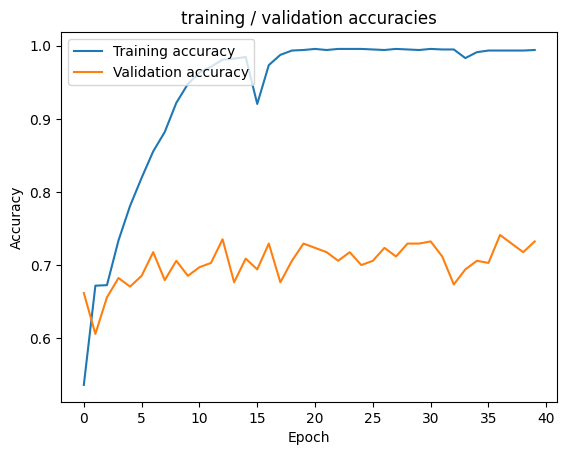

In [ ]:
import matplotlib.pyplot as plt

# plots training and validation accuracy over epochs to visualize the model's learning progress.
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

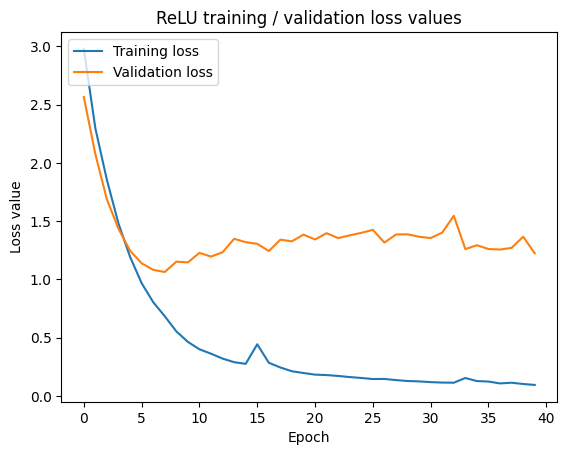

In [ ]:
# plots training and validation loss over epochs.
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Calc type dataset

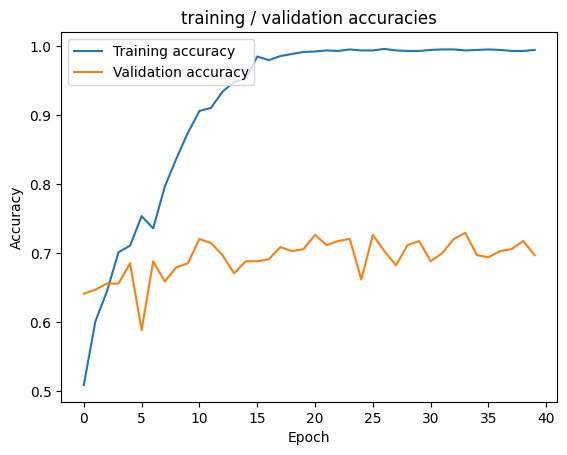

In [ ]:
# plots training and validation accuracy over epochs to visualize the model's learning progress.
plt.plot(history1.history['accuracy'], label='Training accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

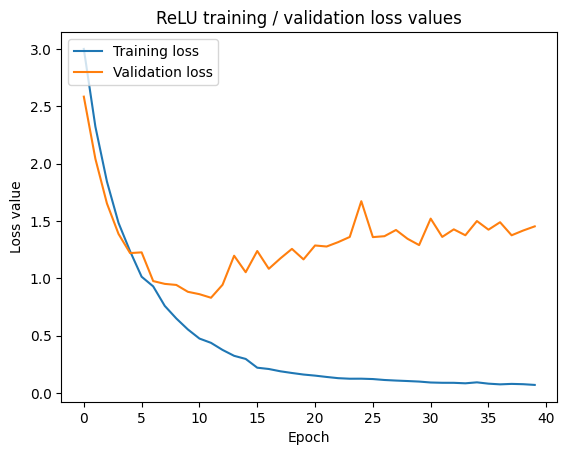

In [ ]:
# plots training and validation loss over epochs.
plt.plot(history1.history['loss'], label='Training loss')
plt.plot(history1.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Mass type dataset (With Cross Validation)

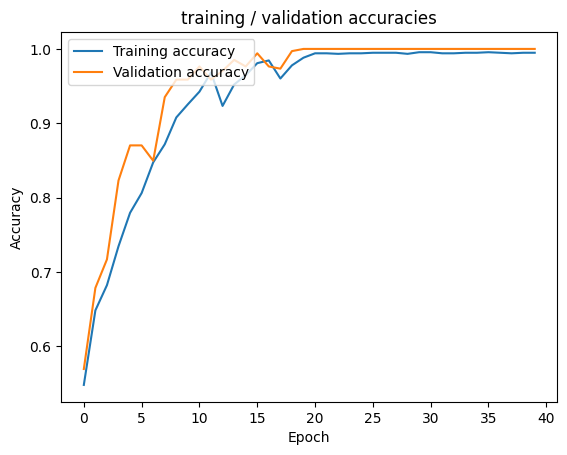

In [ ]:
# plots training and validation accuracy over epochs to visualize the model's learning progress.
plt.plot(history2.history['accuracy'], label='Training accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

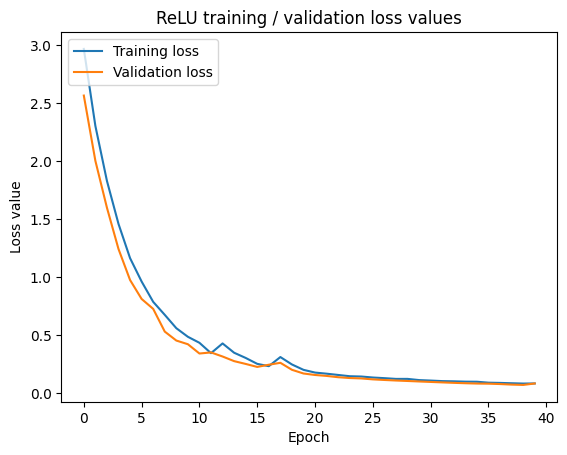

In [ ]:
# plots training and validation loss over epochs.
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Calc type dataset (With Cross Validation)

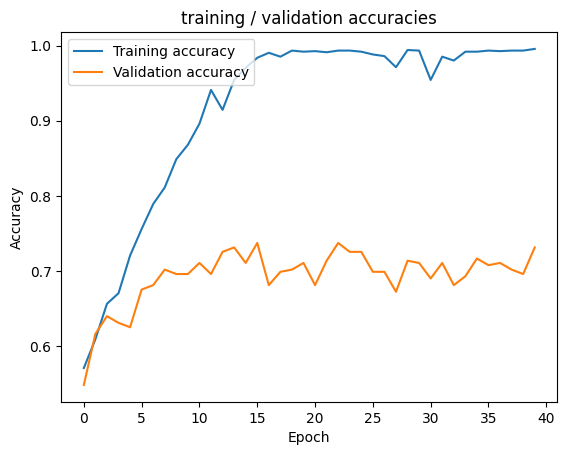

In [ ]:
# plots training and validation accuracy over epochs to visualize the model's learning progress.
plt.plot(history3.history['accuracy'], label='Training accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

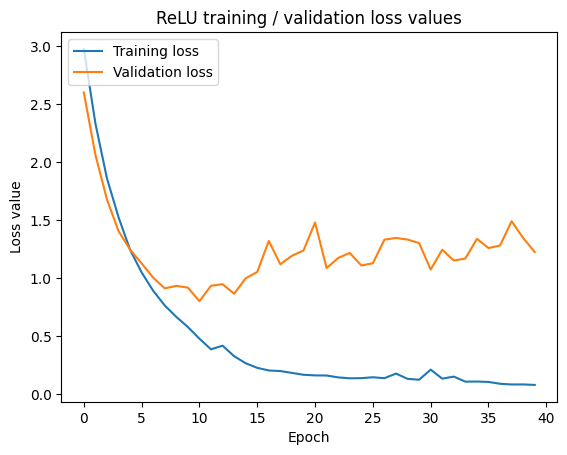

In [ ]:
# plots training and validation loss over epochs.
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Mass (Categorical)

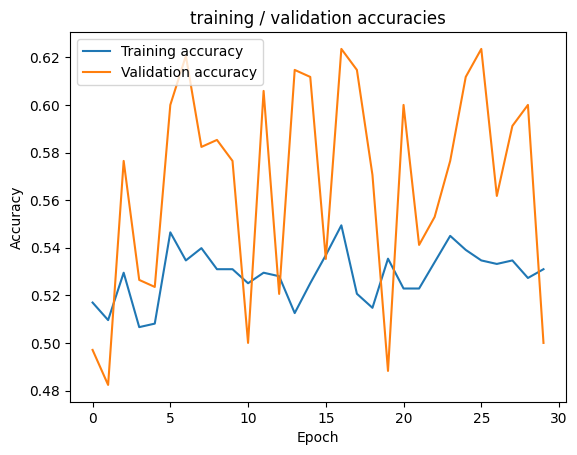

In [ ]:
# plots training and validation accuracy over epochs to visualize the model's learning progress.
plt.plot(history4.history['accuracy'], label='Training accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

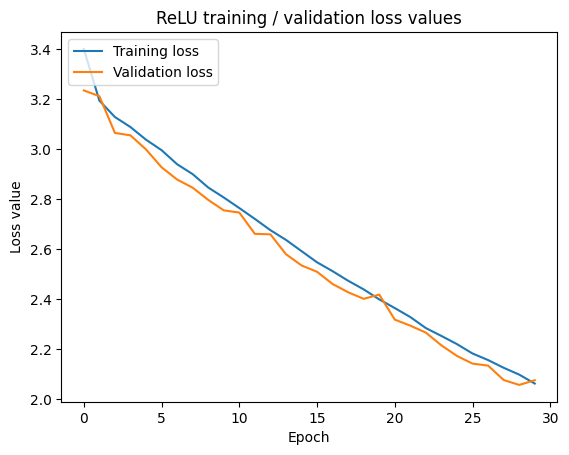

In [ ]:
# plots training and validation loss over epochs.
plt.plot(history4.history['loss'], label='Training loss')
plt.plot(history4.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Calc (Categorical)

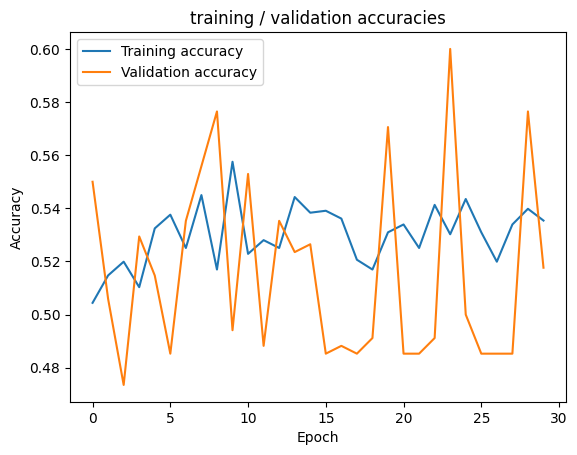

In [ ]:
# plots training and validation accuracy over epochs to visualize the model's learning progress.
plt.plot(history5.history['accuracy'], label='Training accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

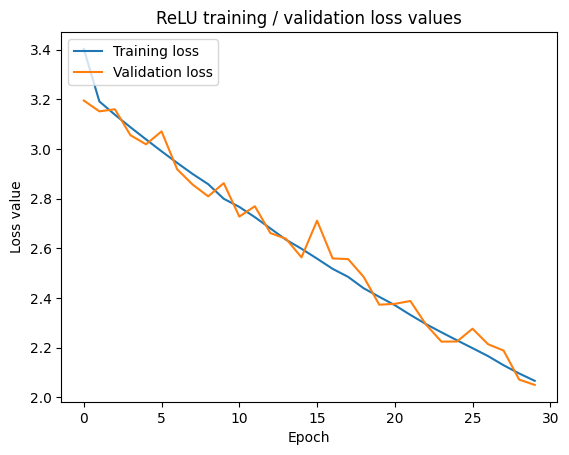

In [ ]:
# plots training and validation loss over epochs.
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Mass (BatchNormalization Dropout)

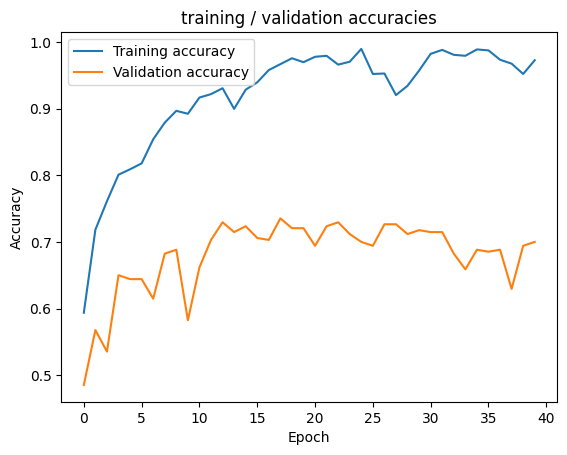

In [64]:
plt.plot(history6.history['accuracy'], label='Training accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

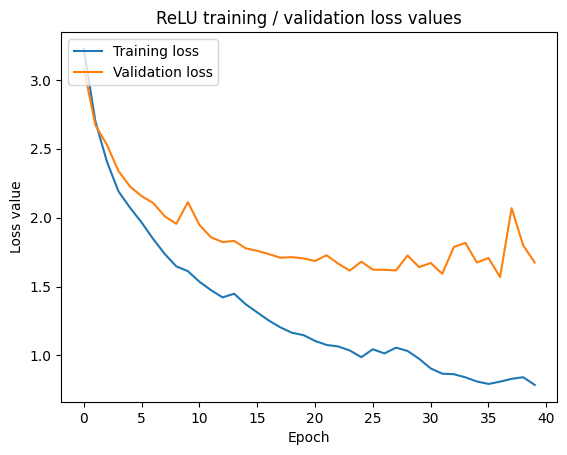

In [65]:
plt.plot(history6.history['loss'], label='Training loss')
plt.plot(history6.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

## Learning rate for Calc (BatchNormalization Dropout)

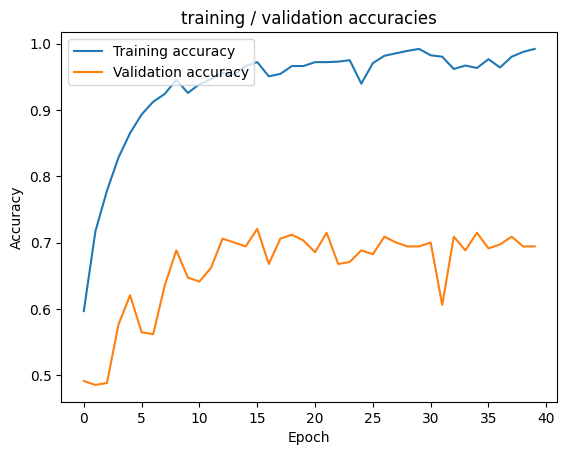

In [70]:
plt.plot(history7.history['accuracy'], label='Training accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation accuracy')
plt.title('training / validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

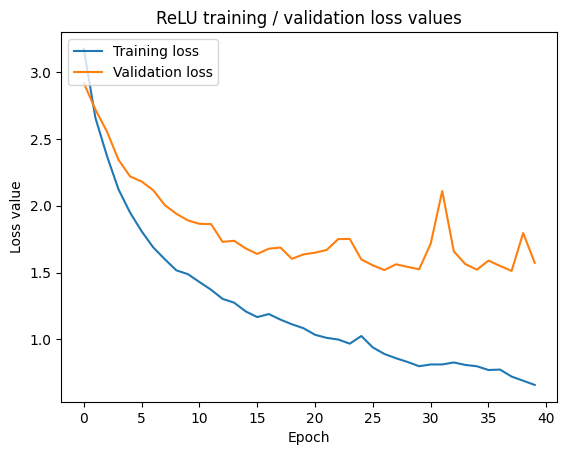

In [71]:
plt.plot(history7.history['loss'], label='Training loss')
plt.plot(history7.history['val_loss'], label='Validation loss')
plt.title('ReLU training / validation loss values')
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

# Results and Reflection

| Dataset Type | Model                                    | Training Loss | Training Accuracy | E_in  | Test Loss | Test Accuracy | E_out  | Model Result              |
|--------------|------------------------------------------|---------------|-------------------|-------|-----------|---------------|--------|---------------------|
| Mass Type    | CNN Output Predictions - VGG16 - ReLU Sigmoid | 0.0875        | 0.9963            | 0.0037| 1.2247    | 0.7324        | 0.2676 | Overfitting         |
| Mass Type    | K-fold Validation                        | 0.4311        | 0.9278            | 0.0722| 0.0828    | 1.0000        | 0.0000 | Underfitting (Error) |
| Mass Type    | Varying hyperparameters ELU Softmax      | 2.0336        | 0.5605            | 0.4395| 2.0766    | 0.5000        | 0.5000 | Underfitting        |
| Mass Type    | BatchNormalization Dropout               | 0.8342        | 0.9403            | 0.0597| 1.6745    | 0.7000        | 0.3000 | Overfitting         |
| Calc Type    | CNN Output Predictions - VGG16 - ReLU Sigmoid | 0.0648        | 0.9963            | 0.0037| 1.4531    | 0.6971        | 0.3029 | Overfitting         |
| Calc Type    | K-fold Validation                        | 0.0789        | 0.9956            | 0.0044| 1.2262    | 0.7316        | 0.2684 | Overfitting         |
| Calc Type    | Varying hyperparameters ELU Softmax      | 2.0249        | 0.5870            | 0.4130| 2.0496    | 0.5176        | 0.4824 | Underfitting        |
| Calc Type    | BatchNormalization Dropout               | 0.6415        | 0.9956            | 0.0044| 1.5724    | 0.6941        | 0.3059 | Overfitting         |


# Evaluation based on other contributers on Kaggle

| Rank | Name             | Test Loss | Test Accuracy | Source                                                                                       |
|------|------------------|-----------|---------------|----------------------------------------------------------------------------------------------|
| 1    | Custom Setup           | 0.1352    | 0.9608        | [Kaggle](https://www.kaggle.com/code/samrudhau/breast-cancer-detection)                       |
| 2    | Our VGG16 Setup    | 1.2247    | 0.7324        | This notebook                                                                                          |
| 3    | VGG16           | 2.3218    | 0.6853        | [Kaggle](https://www.kaggle.com/code/ahmedmedhat1012/cbis-ddsm-breast-cancer-image-dataset-training)   |
| 4    | InceptionResNetv2           | 2.3876    | 0.6529        | [Kaggle](https://www.kaggle.com/code/aruzhanimasheva/cbis-ddsm-breast-cancer-image-dataset-training) |
| 5    | EfficientNetB2           | 0.6777    | 0.5875        | [Kaggle](https://www.kaggle.com/code/krsandeep06/efficientnet-cbis-ddsm/notebook)             |
